https://matthewmcateer.me/blog/practical-causal-inference/

In [49]:
import dowhy
from dowhy import CausalModel
from dowhy import datasets
import pandas as pd
import numpy as np
import scipy
import sklearn
import pygraphviz
import networkx
import matplotlib
import sympy
from IPython.display import Image, display

### Stage 1: Modelling (loading the data and hypoteses)

In [61]:
data = dowhy.datasets.linear_dataset(beta=10,
                                     num_common_causes=5,
                                     num_instruments = 2,
                                     num_samples=10000,
                                     treatment_is_binary=True)

df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.622355,0.264198,0.422683,-1.355990,-1.436689,1.973459,True,10.550691
1,0.0,0.027655,0.767119,0.251205,1.235107,-0.082673,1.488214,True,13.160380
2,0.0,0.275165,-0.971389,1.367051,-0.503725,0.177459,1.785789,True,12.743506
3,0.0,0.341295,0.630761,1.911691,-0.856262,-2.273272,1.096960,False,0.417699
4,0.0,0.589165,0.753175,1.907075,-0.664150,-0.479401,1.503372,True,14.329395


Our dataset is going to have a linear relationship, represented by a slope β = 10.

The current version of DoWhy supports two formats for graph input: gml (preferred) and dot.

Z0 and Z1 represent the instrumental variables for the treatment and outcome, respectively.

Let us create a model to find the causal effect of treatment 'v0' on outcome 'y'

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


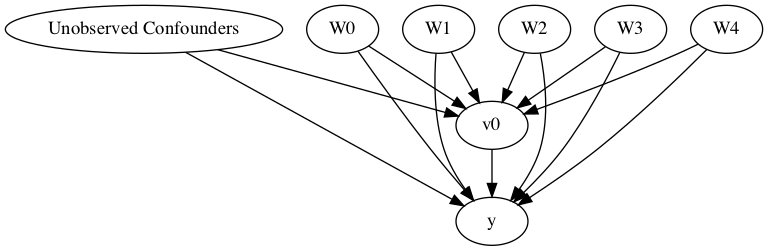

In [52]:
# With graph
model=CausalModel(
        data = df,
        treatment=['v0'],
        outcome=['y'],
        graph=data["gml_graph"]
        )
model.view_model()
display(Image(filename="causal_model.png"))

### Stage2: Identification (What kinds of causal models can be build from this?)

Using the input graph, DoWhy finds all possible ways of identifying a desired causal effect based on the graphical model. It can ignore the data and only use the graph of the relationships. It uses graph-based criteria and do-calculus to find potential ways find expressions that can identify the causal effect.


In [53]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W1', 'W0', 'Unobserved Confounders', 'W4', 'W2', 'W3']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W4,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W2,W3,U) = P(y|v0,W1,W0,W4,W2,W3)
### Estimand : 2
Estimand name: iv
No such variable found!



Since the dataset is by default a simple linear model, we can describe the effect of v0 on y via a simple linear regression model with the slope of β:

β=(d/dv0) E(y∣X0,X2,X1,X3,X4)

This expression (β) can be evaluated in the estimation step. It is important to understand that the identification and estimation are orthogonal steps.

### Stage 3: Estimation (getting actual values for our model)

Now we can produce the causal estimate. DoWhy estimates the causal effect using statistical methods such as matching or instrumental variables. 

The current version of DoWhy supports estimation methods based such as propensity-based-stratification or propensity-score-matching. These methods focus on a combination of regression techniques and estimates of the treatment response.

In [54]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.172e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:29:33   Log-Likelihood:             2.9037e+05
No. Observations:               10000   AIC:                        -5.807e+05
Df Residuals:                    9993   BIC:                        -5.807e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.187e-14   1.43e-15    -36.157      0.0

### Stage 4: Verification (how stable is this model?)

In [55]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3+w_random


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.135e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:29:41   Log-Likelihood:             2.8914e+05
No. Observations:               10000   AIC:                        -5.783e+05
Df Residuals:                    9992   BIC:                        -5.782e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.94e-14   1.62e-15    -30.444      0.0

In [57]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:04   Log-Likelihood:                -25854.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0904      0.064     79.159      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:04   Log-Likelihood:                -25854.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0804      0.064     78.847      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:05   Log-Likelihood:                -25854.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0331      0.064     78.228      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:05   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0540      0.064     78.374      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:05   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0665      0.064     78.998      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:05   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0727      0.064     78.708      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:06   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0474      0.064     78.595      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:06   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0749      0.064     78.903      0.0

INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:06   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0528      0.065     78.266      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:06   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0548      0.064     78.691      0.0

INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.940e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:07   Log-Likelihood:                -25850.
No. Observations:               10000   AIC:                         5.171e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9762      0.065     76.965      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.939e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:07   Log-Likelihood:                -25853.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0102      0.064     77.678      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:07   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0686      0.064     78.888      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:07   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0411      0.065     78.060      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0683      0.064     78.729      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0741      0.064     78.715      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0561      0.064     78.850      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:                -25854.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0273      0.064     78.174      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0666      0.064     78.597      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.939e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:09   Log-Likelihood:                -25854.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0992      0.064     79.153      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:09   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0522      0.064     78.802      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:09   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0670      0.064     78.922      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:09   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0351      0.065     78.013      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:10   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0781      0.064     79.056      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:10   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0396      0.064     78.241      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:10   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0467      0.065     78.182      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:10   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0761      0.064     79.026      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:11   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0789      0.064     78.849      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:11   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0438      0.065     78.196      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:11   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0731      0.065     78.588      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:11   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0545      0.064     78.714      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.938e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:11   Log-Likelihood:                -25855.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0485      0.065     78.205      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W1+W0+W4+W2+W3
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.939e+04
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:30:12   Log-Likelihood:                -25853.
No. Observations:               10000   AIC:                         5.172e+04
Df Residuals:                    9993   BIC:                         5.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0062      0.064     77.788      0.0

#### A large change with the placebo! 

That is, yhe value of β based on how we previously formulated it has collapsed to near 0.

In [60]:
res_subset=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.9 simulated datasets of size 9000.0 each
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.107e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:22   Log-Likelihood:             2.5320e+05
No. Observations:                9000   AIC:                        -5.064e+05
Df Residuals:                    8993   BIC:                        -5.063e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.015e-13   3.73e-15     27.246      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.752e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:23   Log-Likelihood:             2.6149e+05
No. Observations:                9000   AIC:                        -5.230e+05
Df Residuals:                    8993   BIC:                        -5.229e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.899e-14   1.48e-15     33.041      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.652e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:23   Log-Likelihood:             2.6333e+05
No. Observations:                9000   AIC:                        -5.266e+05
Df Residuals:                    8993   BIC:                        -5.266e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.463e-14   1.21e-15    -28.592      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.841e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:23   Log-Likelihood:             2.6673e+05
No. Observations:                9000   AIC:                        -5.334e+05
Df Residuals:                    8993   BIC:                        -5.334e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.76e-14   8.32e-16     21.158      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.552e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:23   Log-Likelihood:             2.5007e+05
No. Observations:                9000   AIC:                        -5.001e+05
Df Residuals:                    8993   BIC:                        -5.001e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.637e-13   5.29e-15     30.962      0.0

INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.316e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:24   Log-Likelihood:             2.6522e+05
No. Observations:                9000   AIC:                        -5.304e+05
Df Residuals:                    8993   BIC:                        -5.304e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.725e-14   9.83e-16    -37.874      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.310e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:24   Log-Likelihood:             2.6020e+05
No. Observations:                9000   AIC:                        -5.204e+05
Df Residuals:                    8993   BIC:                        -5.203e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.052e-14   1.72e-15    -23.562      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.280e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:24   Log-Likelihood:             2.5279e+05
No. Observations:                9000   AIC:                        -5.056e+05
Df Residuals:                    8993   BIC:                        -5.055e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.224e-13    3.9e-15    -31.425      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.988e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:24   Log-Likelihood:             2.5669e+05
No. Observations:                9000   AIC:                        -5.134e+05
Df Residuals:                    8993   BIC:                        -5.133e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.726e-14   2.53e-15     38.492      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.012e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:25   Log-Likelihood:             2.6238e+05
No. Observations:                9000   AIC:                        -5.247e+05
Df Residuals:                    8993   BIC:                        -5.247e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.463e-14   1.34e-15    -33.188      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.319e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:25   Log-Likelihood:             2.6195e+05
No. Observations:                9000   AIC:                        -5.239e+05
Df Residuals:                    8993   BIC:                        -5.238e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.485e-14   1.41e-15    -31.713      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.792e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:25   Log-Likelihood:             2.6660e+05
No. Observations:                9000   AIC:                        -5.332e+05
Df Residuals:                    8993   BIC:                        -5.331e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.413e-14   8.39e-16     28.773      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.094e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:25   Log-Likelihood:             2.5693e+05
No. Observations:                9000   AIC:                        -5.138e+05
Df Residuals:                    8993   BIC:                        -5.138e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.581e-14   2.47e-15     38.804      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.175e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:25   Log-Likelihood:             2.6250e+05
No. Observations:                9000   AIC:                        -5.250e+05
Df Residuals:                    8993   BIC:                        -5.249e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.013e-14   1.33e-15    -22.608      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.470e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:26   Log-Likelihood:             2.6958e+05
No. Observations:                9000   AIC:                        -5.391e+05
Df Residuals:                    8993   BIC:                        -5.391e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.19e-15   6.04e-16      8.591      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.995e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:26   Log-Likelihood:             2.6084e+05
No. Observations:                9000   AIC:                        -5.217e+05
Df Residuals:                    8993   BIC:                        -5.216e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.564e-14    1.6e-15    -22.308      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.963e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:26   Log-Likelihood:             2.6699e+05
No. Observations:                9000   AIC:                        -5.340e+05
Df Residuals:                    8993   BIC:                        -5.339e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.32e-14   8.07e-16    -41.117      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.124e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:26   Log-Likelihood:             2.6001e+05
No. Observations:                9000   AIC:                        -5.200e+05
Df Residuals:                    8993   BIC:                        -5.200e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.184e-14   1.75e-15     35.306      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.178e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:27   Log-Likelihood:             2.7137e+05
No. Observations:                9000   AIC:                        -5.427e+05
Df Residuals:                    8993   BIC:                        -5.427e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.18e-14   4.96e-16     23.790      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.878e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:27   Log-Likelihood:             2.5356e+05
No. Observations:                9000   AIC:                        -5.071e+05
Df Residuals:                    8993   BIC:                        -5.071e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.175e-13    3.6e-15    -32.662      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.889e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:27   Log-Likelihood:             2.6294e+05
No. Observations:                9000   AIC:                        -5.259e+05
Df Residuals:                    8993   BIC:                        -5.258e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.645e-14   1.26e-15     44.773      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.188e+32
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:27   Log-Likelihood:             2.7346e+05
No. Observations:                9000   AIC:                        -5.469e+05
Df Residuals:                    8993   BIC:                        -5.469e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.138e-14   3.92e-16     28.995      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.810e+31
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:27   Log-Likelihood:             2.5629e+05
No. Observations:                9000   AIC:                        -5.126e+05
Df Residuals:                    8993   BIC:                        -5.125e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.729e-14   2.64e-15     33.030      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.233e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:28   Log-Likelihood:             2.5276e+05
No. Observations:                9000   AIC:                        -5.055e+05
Df Residuals:                    8993   BIC:                        -5.055e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.273e-13   3.92e-15    -32.488      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W4+W2+W3
INFO:dowhy.causal_refuters.data_subset_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.826e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:32:28   Log-Likelihood:             2.5250e+05
No. Observations:                9000   AIC:                        -5.050e+05
Df Residuals:                    8993   BIC:                        -5.049e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.117e-13   4.05e-15     27.603      0.0